# Purpose

This notebook is to test whether the `neuro_op` module's nodes can successfully infer `world_dist` if only this distribution's information pieces $x_{world}$ are received (i.e., with rates h>0, r=0).

For this, the model is run with nodes receiving different amount of information (i.e., different `t_max`, `h`). Then, each node's posterior predictive distribution (*PPD*), equalling its forecast of future incoming information, is obtained via 
1. sampling of model parameters $\theta$ proportional to its posterior $p(\theta | x_{world})$;
2. using these sampled model parameters to generate data proportional to the model likelihood $p(x_{PPD}|\theta_{sampled})$

PPDs thereby fully conserves uncertainty by paying respect to both posterior and likelihood stochasticity.

We then use the PPDs to quantify the nodes' modelling accuracy by computing the Kullback-Leibler divergence and average MLE distances between node PPDs and data generated by `world_dist`.

In [23]:
import cProfile

import matplotlib.pyplot as plt
import networkx as nx
import numpy as np
import scipy.stats as st

import neuro_op as nop

In [24]:
# Reference input for 'run_model' function. For description of contents, see 'run_model' function docstring.
input = dict(
    # G=nop.build_random_network(N_nodes=1, N_neighbours=5),  # networkx graph object
    G=nx.empty_graph(1),  # networkx graph object
    mu_arr=np.linspace(-5, 5, 1001),  # beliefs considered by each node
    sd_arr=np.linspace(0, 10, 101)[
        1:
    ],  # standard deviations of beliefs considered by each node
    log_priors=np.zeros((1001, 100)),  # Prior log-probabilities of nodes
    llf_nodes=st.norm,  # Likelihood function (llf) of nodes, Gaussian by default
    llf_world=st.norm,  # Likelihood function (llf) of to-be-approximated world state, Gaussian by default
    params_world=dict(  # Likelihood function (llf) parameters of to-be-approximated world state, Gaussian by default
        loc=0,
        scale=1,
    ),
    h=1,  # Rate of external information draw events
    r=0,  # Rate of edge information exchange events
    t0=0,  # Start time of simulation
    t_max=1000,  # End time of simulation
    t_sample=1,  # Periodicity for which mu_nodes and KLD are sampled
    sample_range=(
        -3,
        3,
    ),  # Interval over which distance measure distributions are considered
    sample_bins=601,  # Number of bins used in distance measures
    sampling=True,
    init_rngs=True,
)

In [25]:
# cProfile.run("nop.run_Grid(**input)")

In [26]:
# out1 = nop.run_Grid(**nop.input_ref_Grid)
out1 = nop.run_Grid(**input)

print(out1["N_events"])

999


In [27]:
nop.export_hdf5(out1, "test.h5")
out_1 = nop.import_hdf5("test.h5")

## Data analysis

Random data analysis test notebook of steps later used in thorough analysis.


In [28]:
# For improving of readability, increase all font sizes of plots. Also, set legend location to upper right.
plt.rcParams.update(
    {
        "font.size": 20,
        "legend.loc": "upper right",
    }
)

#### Data analysis 1

Firstly, extract output values for further analysis:

In [29]:
for i in out1.keys():
    print(i)

nodesGrid
world
G
N_events
t_end
t_start
t_exec
seed
mu_arr
sd_arr
mu_nodes
kl_divs



Each node's posteriors are plotted. One should see nodes' posteriors of model parameters (in this case, $\mu$), to converge around the true value. If not, nodes may need more information to converge ($\rightarrow$ increase $t_{max}, h$).


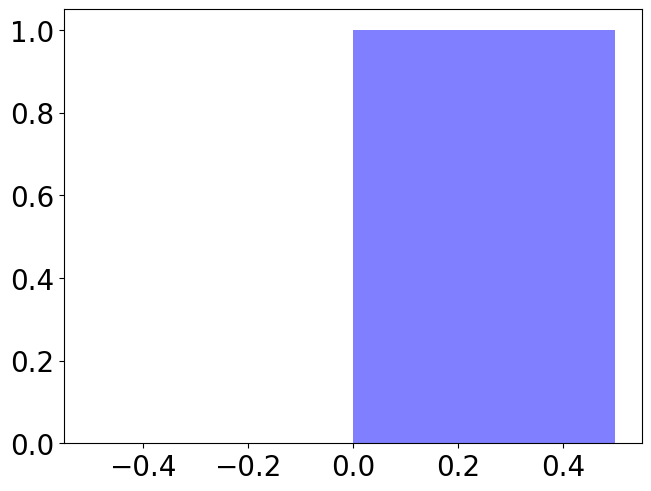

In [30]:
mu = np.array(out1["mu_nodes"])
mu_tmp = mu[0]


def pairwise_hist(stances):
    distances = abs(stances - stances[:, None])
    fig, ax = plt.subplots(1, 1, constrained_layout=True)
    ax.hist(
        distances.flatten(),
        bins=int(np.ceil(2 * len(stances) ** (1 / 3))),
        alpha=0.5,
        color="b",
    )

    return fig, ax


fig, ax = pairwise_hist(mu_tmp)

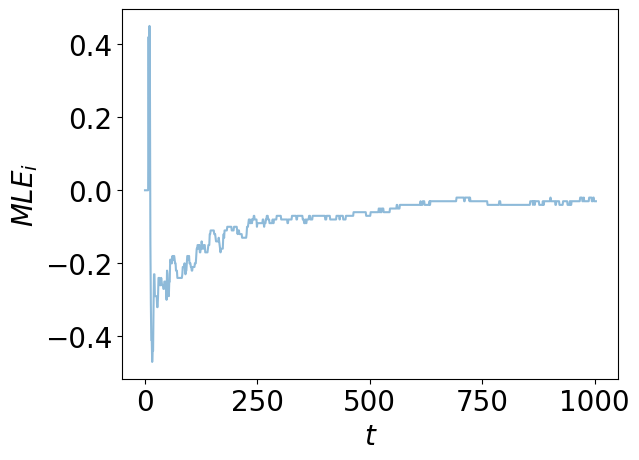

In [31]:
mu_arr = np.array(out1["mu_nodes"])
x = np.arange(mu_arr.shape[0]) * input["t_sample"]
for i, _ in enumerate(mu_arr.T):
    plt.plot(x, mu_arr.T[i], alpha=0.5, label=f"Node {i}")
    plt.xlabel("$t$")
    plt.ylabel("$MLE_i$")
# plt.ylim(-5, 5)

#### Data analysis 2

In [32]:
N_iter = range(input["G"].number_of_nodes())
kld = np.array(out1["kl_divs"])
kld.shape

(1004, 1)

[]

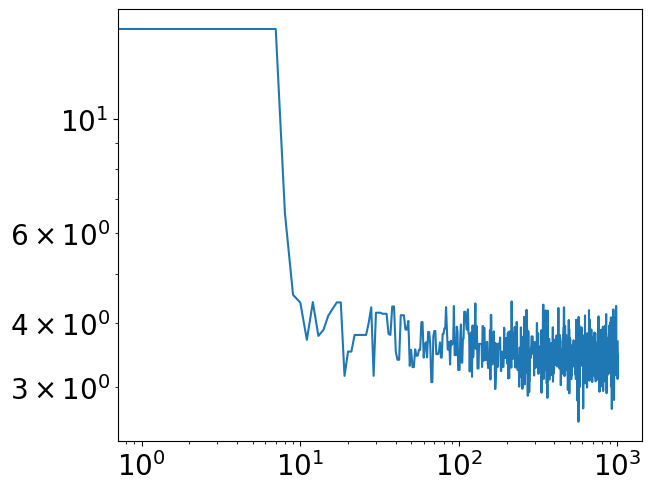

In [33]:
i = 1
fig, ax = plt.subplots(1, 1, constrained_layout=True)
ax.plot(
    # input["t_sample"] * np.arange(0, kld.shape[0]),
    kld.mean(axis=i),
    label="avg",
)
ax.loglog()
# ax.set_yscale("log")